**Sprint 3: Machine Learning Preparation**
**Goal:** Develop model inputs and target variables.

**Tasks:**

1. **Creating the Target Variable: Energy Output Prediction**

   * Create the target variable `Power_Output`, which predicts the next hour's energy production.

2. **Creating Time and Weather-Dependent Features**

   * Extract features such as day of the week, hour, and average weather conditions over the past 6 hours.

3. **Encoding Categorical Features**

   * Convert weather categories into a format suitable for the model (e.g., using one-hot encoding).

4. **Normalizing and Scaling Features**

   * Normalize all numerical features using either MinMaxScaler or StandardScaler.

5. **Splitting the Dataset into Training and Test Sets**

   * Split the dataset into 80% training and 20% testing in a time-ordered manner.

### Small comment:

Just like before, we handle paths and then load our thing. I have to think how to fix this to be scalable. 

So, one good point is now we should not have the `Unnamed: 0` column at all.

In [19]:
from tomodachi_core.models.weather_impact_model.tomodachi_model import TomodachiModel
from tomodachi_core.tomodachi.services import PandasService
from config_loader import load_config

import pandas as pd
import numpy as np

import os
import pathlib


# get curr dir
current_dir = os.getcwd()

# find the root using patlihb
root_dir = pathlib.Path(current_dir).parents[0].resolve()

# path to the config
config_path = (root_dir / "tomodachi_core" / "config_development" / "config.py").resolve()

# load the config
config = load_config(config_path)

# Grab the CSV_PATH
CSV_PATH = config.SAVE_TO_PATH
DIRTY_PATH = config.CSV_PATH


# Finally, we have to combine the path
CSV_PATH = (root_dir / CSV_PATH).resolve()
DIRTY_PATH = (root_dir / DIRTY_PATH).resolve() # For checking out imputer work

# Create PandasService
pandas_service = PandasService(str(CSV_PATH))

# load the data
df = pandas_service.load_csv_data()

Path C:\Users\Lenovo\Desktop\python_app\tuuleenergia_tomodachi exists.


In [2]:
# Make sure we got beautiful df
print(df.head(6))

            Timestamp  Wind_Speed  Wind_Gust  Wind_Direction  Temperature  \
0 2020-01-01 00:00:00    0.265077   4.876651             274     2.152885   
1 2020-01-01 01:00:00   10.727089  13.030088             232    -9.783598   
2 2020-01-01 02:00:00   16.280163  17.651853             175     2.125048   
3 2020-01-01 03:00:00    5.110434   9.387124             235    -0.174307   
4 2020-01-01 04:00:00   16.444265  20.349305               1     1.881483   
5 2020-01-01 05:00:00   17.641930  18.989849             352     8.668347   

    Humidity  Precipitation     Pressure  Cloud_Cover  Solar_Radiation  \
0  88.345267       8.519070   997.887007    18.112024       359.985040   
1  70.172549       0.604355  1021.258081    76.901148       414.169416   
2  73.305597       2.239670   983.310126    49.615723       150.986509   
3  60.924091       1.314233  1032.161577    48.975636       879.761958   
4  78.893660       9.442267   951.217727    48.506623       752.151006   
5  76.722646    

In [3]:
# Check the types
print(df.dtypes)

Timestamp             datetime64[ns]
Wind_Speed                   float64
Wind_Gust                    float64
Wind_Direction                 int64
Temperature                  float64
Humidity                     float64
Precipitation                float64
Pressure                     float64
Cloud_Cover                  float64
Solar_Radiation              float64
Hour_of_Day                    int64
Day_of_Week                    int64
Month                          int64
Wind_Speed_Squared           float64
Wind_Speed_Cubed             float64
Power_Output                 float64
Precipitation_Unit            object
dtype: object


### Actual SPRINT-3 job:

In [4]:
# Step 1
df["Power_Output"] = df["Power_Output"].shift(-1)
df = df.dropna()

In [5]:
X = df.drop(columns=["Power_Output", "Timestamp"])
y = df["Power_Output"]

In [6]:
# Step 2

weather_cols = ['Temperature', 'Humidity', 'Wind_Speed', 'Wind_Gust', 'Pressure', 'Solar_Radiation']

time_features = X[["Hour_of_Day", "Day_of_Week", "Month"]]

for col in weather_cols:
    X[f'{col}_6h_avg'] = df[col].rolling(window=6).mean().shift(1)  # shift 1 hour to avoid leakage

In [10]:
# Step 3
from tomodachi_core.tomodachi.services.preprocess import PreprocessData

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
num_features = ['Temperature', 'Humidity', 'Wind_Speed', 'Wind_Gust', 'Pressure'] + [f'{c}_6h_avg' for c in weather_cols]
mini_max_feature = ['Solar_Radiation']
cat_features = ['Precipitation_Unit', 'Hour_of_Day', 'Day_of_Week', 'Month']  # if you want to treat time features categorically

preprocessor = PreprocessData().preprocess(X, y)

preprocessor.set_feature_groups(
    num_features=num_features,
    mini_max_feature=mini_max_feature,
    cat_features=cat_features
)

# Step 3: Fit on training data
X_train_processed = preprocessor.fit_transform(X_train)

# Step 4: Transform test data
X_test_processed = preprocessor.transform(X_test)

In [12]:
X_train_processed

array([[ 1.25973588, -2.24458906, -1.05769071, ...,  0.        ,
         0.        ,  0.        ],
       [-1.52008957,  2.00724556,  0.34717039, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0103964 , -2.03859119, -0.46072559, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.0103964 , -0.24938231,  1.14902258, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22143798,  0.64561089, -0.13428514, ...,  1.        ,
         0.        ,  0.        ],
       [-0.34983278, -0.2704829 , -0.64319758, ...,  0.        ,
         0.        ,  0.        ]], shape=(23999, 59))

In [13]:
X_test_processed

array([[-1.45339036,  1.22265038,  0.55910919, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.51900898, -0.00535717, -0.39368611, ...,  0.        ,
         0.        ,  0.        ],
       [-0.40008461, -0.52785934,  1.00796192, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.71102225, -1.73306042, -0.55588933, ...,  0.        ,
         0.        ,  0.        ],
       [-1.48238347, -0.00535717,  0.38416589, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.08515586, -0.40936642,  0.80848074, ...,  0.        ,
         0.        ,  0.        ]], shape=(6000, 59))

In [21]:
preprocessor.feature_names_in_

array(['Wind_Speed', 'Wind_Gust', 'Wind_Direction', 'Temperature',
       'Humidity', 'Precipitation', 'Pressure', 'Cloud_Cover',
       'Solar_Radiation', 'Hour_of_Day', 'Day_of_Week', 'Month',
       'Wind_Speed_Squared', 'Wind_Speed_Cubed', 'Precipitation_Unit',
       'Temperature_6h_avg', 'Humidity_6h_avg', 'Wind_Speed_6h_avg',
       'Wind_Gust_6h_avg', 'Pressure_6h_avg', 'Solar_Radiation_6h_avg'],
      dtype=object)

In [22]:
preprocessor.n_features_in_

21

### Sklearn

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("mini_max", MinMaxScaler(), mini_max_feature),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

X_scaled = preprocessor.fit_transform(X, y)

In [18]:
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
all_features = np.concatenate([num_features, mini_max_feature, cat_feature_names])
print("Final feature names:", all_features)

Final feature names: ['Temperature' 'Humidity' 'Wind_Speed' 'Wind_Gust' 'Pressure'
 'Temperature_6h_avg' 'Humidity_6h_avg' 'Wind_Speed_6h_avg'
 'Wind_Gust_6h_avg' 'Pressure_6h_avg' 'Solar_Radiation_6h_avg'
 'Solar_Radiation' 'Precipitation_Unit_ML' 'Precipitation_Unit_Mm'
 'Precipitation_Unit_milimeter' 'Precipitation_Unit_mm' 'Hour_of_Day_0'
 'Hour_of_Day_1' 'Hour_of_Day_2' 'Hour_of_Day_3' 'Hour_of_Day_4'
 'Hour_of_Day_5' 'Hour_of_Day_6' 'Hour_of_Day_7' 'Hour_of_Day_8'
 'Hour_of_Day_9' 'Hour_of_Day_10' 'Hour_of_Day_11' 'Hour_of_Day_12'
 'Hour_of_Day_13' 'Hour_of_Day_14' 'Hour_of_Day_15' 'Hour_of_Day_16'
 'Hour_of_Day_17' 'Hour_of_Day_18' 'Hour_of_Day_19' 'Hour_of_Day_20'
 'Hour_of_Day_21' 'Hour_of_Day_22' 'Hour_of_Day_23' 'Day_of_Week_0'
 'Day_of_Week_1' 'Day_of_Week_2' 'Day_of_Week_3' 'Day_of_Week_4'
 'Day_of_Week_5' 'Day_of_Week_6' 'Month_1' 'Month_2' 'Month_3' 'Month_4'
 'Month_5' 'Month_6' 'Month_7' 'Month_8' 'Month_9' 'Month_10' 'Month_11'
 'Month_12']


In [20]:
X_scaled_dense = X_scaled.toarray()
X_scaled_df = pd.DataFrame(X_scaled_dense, columns=all_features)
print(X_scaled_df.head())

   Temperature  Humidity  Wind_Speed  Wind_Gust  Pressure  Temperature_6h_avg  \
0    -0.458549  2.024266   -1.505153  -1.374700 -0.075770                 NaN   
1    -1.659070  0.378803   -0.164144  -0.265959  0.734161                 NaN   
2    -0.461349  0.662487    0.547643   0.362529 -0.580936                 NaN   
3    -0.692608 -0.458605   -0.884080  -0.761346  1.112024                 NaN   
4    -0.485846  1.168463    0.568678   0.729341 -1.693106                 NaN   

   Humidity_6h_avg  Wind_Speed_6h_avg  Wind_Gust_6h_avg  Pressure_6h_avg  ...  \
0              NaN                NaN               NaN              NaN  ...   
1              NaN                NaN               NaN              NaN  ...   
2              NaN                NaN               NaN              NaN  ...   
3              NaN                NaN               NaN              NaN  ...   
4              NaN                NaN               NaN              NaN  ...   

   Month_3  Month_4  Month

### IMPUTER: Little Recap (Imputer vs ColumnTransofmer)

In [23]:
my_service = PandasService(str(DIRTY_PATH))
df = my_service.load_csv_data()

In [24]:
df

,Timestamp,Wind_Speed,Wind_Gust,Wind_Direction,Temperature,Humidity,Precipitation,Pressure,Cloud_Cover,Solar_Radiation,Hour_of_Day,Day_of_Week,Month,Wind_Speed_Squared,Wind_Speed_Cubed,Power_Output,Precipitation_Unit
0,2020-01-01 00:00:00,0.265077,4.876651,274,2.152885,88.345267,8.519070,997.887007,18.112024,359.985040,0,2,1,0.070266,0.018626,6.001146,mm
1,2020-01-01 01:00:00,10.727089,13.030088,232,-9.783598,70.172549,0.604355,1021.258081,76.901148,414.169416,1,2,1,115.070448,1234.370982,128.699686,mm
2,2020-01-01 02:00:00,16.280163,17.651853,175,2.125048,73.305597,2.239670,983.310126,49.615723,150.986509,2,2,1,265.043714,4314.954915,370.222084,mm
3,2020-01-01 03:00:00,5.110434,9.387124,235,-0.174307,60.924091,1.314233,1032.161577,48.975636,879.761958,3,2,1,26.116535,133.466829,-30.746944,mm
4,2020-01-01 04:00:00,16.444265,20.349305,1,1.881483,78.893660,9.442267,951.217727,48.506623,752.151006,4,2,1,270.413853,4446.757073,495.256687,mm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30295,2023-03-09 00:00:00,19.155799,21.753286,48,NaN,71.432872,8.045355,970.138601,19.993591,981.661646,0,3,3,366.944632,7029.117569,697.938093,mm
30296,2021-06-20 04:00:00,4.255135,6.760641,143,29.918565,68.584030,3.477158,962.814249,22.214235,437.033112,4,6,6,18.106171,77.044199,28.517725,mm
30297,2021-03-26 06:00:00,14.315677,15.489399,47,3.875054,50.875164,1.915244,1014.743275,98.855762,162.440760,6,4,3,204.938595,2933.834635,362.628620,mm
30298,2020-03-27 13:00:00,18.209074,23.172418,71,7.155587,64.865156,5.935101,1035.863647,20.872151,953.018941,13,4,3,331.570365,6037.589202,607.445627,mm


In [26]:
X = df.drop(columns=["Power_Output", "Precipitation_Unit", "Timestamp"])
y = df["Power_Output"]
X = X.dropna()
y = y.dropna()
preprocessor_raw = PreprocessData.preprocess(X, y)

# apply imputer
result = preprocessor_raw.imputer_preprocess(strategy='most_frequent')
print(result.unwrap())

       Wind_Speed  Wind_Gust  Wind_Direction  Temperature   Humidity  \
0        0.265077   4.876651           274.0     2.152885  88.345267   
1       10.727089  13.030088           232.0    -9.783598  70.172549   
2       16.280163  17.651853           175.0     2.125048  73.305597   
3        5.110434   9.387124           235.0    -0.174307  60.924091   
4       16.444265  20.349305             1.0     1.881483  78.893660   
...           ...        ...             ...          ...        ...   
24659    9.044529  10.490345            88.0     0.417861  85.128582   
24660    4.255135   6.760641           143.0    29.918565  68.584030   
24661   14.315677  15.489399            47.0     3.875054  50.875164   
24662   18.209074  23.172418            71.0     7.155587  64.865156   
24663    2.660925   5.066079           191.0     1.515736  63.662077   

       Precipitation     Pressure  Cloud_Cover  Solar_Radiation  Hour_of_Day  \
0           8.519070   997.887007    18.112024       35

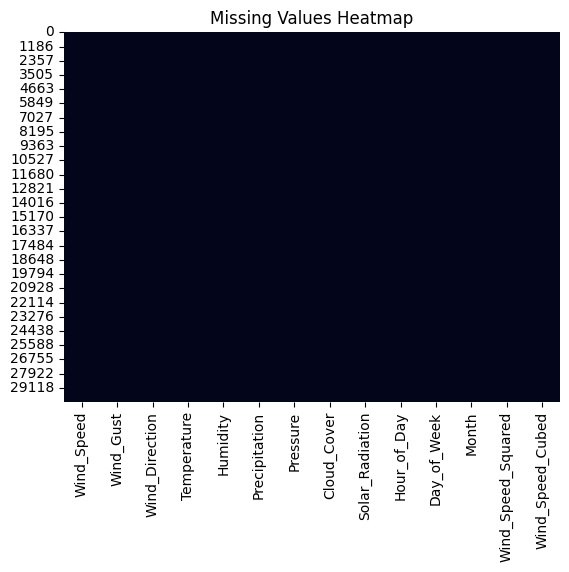

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(X.isna(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()
